In [2]:
%precision %.2f
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import pandas as pd
import numpy as np
import scipy.stats as stats
import src.compute.developer as developer

from datetime import date
from src.compute.utils import Interval, statuses_of_interest
from src.db.utils import SnowflakeWrapper
from src.config import data_root

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
conn = SnowflakeWrapper.create_snowflake_connection()
sw = SnowflakeWrapper(conn)

In [3]:


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    # can't be used because we don't have the same distribution in our data
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [4]:
active_interval: Interval = Interval(
    # fromDate=date(2019, 7, 1), # year, month, day
    # toDate=date(2019, 10, 1),
    fromDate=date(2019, 10, 1), # year, month, day
    toDate=date(2020, 1, 1)
)
print("Active interval:", active_interval)

Active interval: ('2019-10-01', '2020-01-01')


In [5]:
by_status = developer.get_all_developers_by_status(sw, active_interval)
# TODO: the data does not take into account the number of issues the user had
#   e.g. there are users with 1 issue in CodeReview and his/her mean value is 1 day
#   then there are some users with 10+ issues in CodeReview and their mean value is 5+ days

status = "Testing"
data = by_status[status].set_index("USERID")
by_day = data["AVG_DAY"].dropna()
print(len(by_day), len(data["AVG_DAY"]))
by_day_na = data["AVG_DAY"]
chosen_user = data.loc['marko.prelevikj', :]

57 197


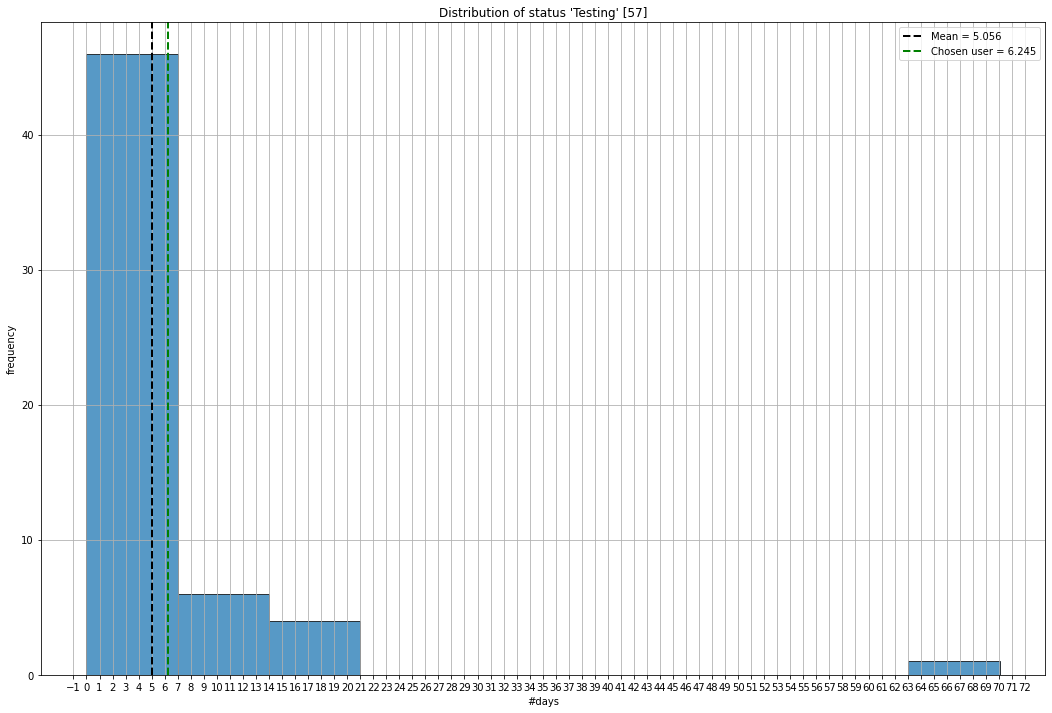

In [8]:
num_bins = 10
fig = plt.figure()
plt.hist(by_day, bins=num_bins, alpha=0.75, edgecolor='black')
plt.xticks(np.arange(np.ceil(by_day.min()) - 2,np.ceil(by_day.max()) + 2,1))
plt.axvline(by_day.mean(), color='black', linestyle='dashed', linewidth=2, label=f"Mean = {by_day.mean():.3f}")
plt.axvline(chosen_user["AVG_DAY"], color='g', linestyle='dashed', linewidth=2, label=f'Chosen user = {chosen_user["AVG_DAY"]:.3f}')

plt.title(f"Distribution of status '{status}' [{len(by_day)}]")
plt.xlabel("#days")
plt.ylabel("frequency")
plt.legend()
plt.grid()
plt.savefig(f"{data_root}/figs/dev_comparison_{status}_hist.png")
plt.show()

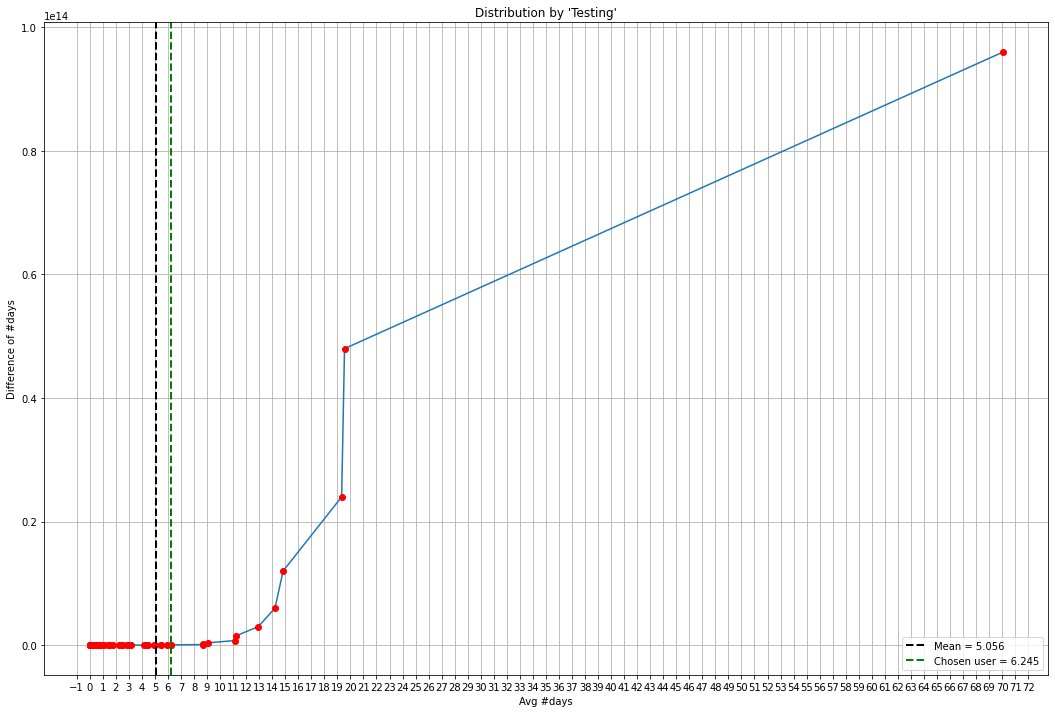

In [7]:
# plot power law (?)
sorted_by_day = by_day.sort_values()
cum_sum = 0
diffs = [0]
for x, y in zip(sorted_by_day, sorted_by_day[1:]):
    diff = y - x + cum_sum
    cum_sum += diff
    diffs.append(diff)

fig = plt.figure()
plt.plot(sorted_by_day, diffs)
plt.plot(sorted_by_day, diffs, 'ro')
plt.xticks(np.arange(np.ceil(by_day.min()) - 2,np.ceil(by_day.max()) + 2,1))
plt.axvline(by_day.mean(), color='k', linestyle='dashed', linewidth=2, label=f"Mean = {by_day.mean():.3f}")
plt.axvline(chosen_user["AVG_DAY"], color='g', linestyle='dashed', linewidth=2, label=f'Chosen user = {chosen_user["AVG_DAY"]:.3f}')
plt.xlabel("Avg #days")
plt.ylabel("Difference of #days")
plt.title(f"Distribution by '{status}'")
plt.grid()
plt.legend()
plt.savefig(f"{data_root}/figs/dev_comparison_{status}_plot.png")
plt.show()